# Машинное обучение, ФКН ВШЭ

## Практическое задание 4. Классификация

### Общая информация
Дата выдачи: 16.11.2024

Мягкий дедлайн: 28.11.2024

Жесткий дедлайн: 02.12.2024

In [3]:
import numpy as np
import pandas as pd
# import polars as pl
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
# pl.Config().set_tbl_rows(100)
# pl.Config().set_tbl_cols(100)

from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split

In [58]:
!pip install optuna

# __Бонусная часть. Многоклассовая классификация__ (1.5 балла)

Как известно, некоторые задачи не ограничиваются всего лишь двумя классами. На лекции вы проходили несколько способов обобщения линейных моделей на этот случай: One-vs-Rest и One-vs-One. Ниже мы посмотрим, в чём преимущества и недостатки обоих подходов, а так же попробуем ещё один чуть более экзотический метод

#### **Задание 14. One-vs-Rest vs One-vs-One** (0.5 балла)

В качестве [датасета](https://www.kaggle.com/datasets/thedevastator/higher-education-predictors-of-student-retention/data) здесь и ниже мы будем брать очень жизненные и актуальные данные о том, доучится студент или нет, в зависимости от курсов, возраста, гендера и прочих (не)осуждаемых признаков.

In [4]:
import kagglehub

path = kagglehub.dataset_download("thedevastator/higher-education-predictors-of-student-retention") + "/dataset.csv"

features = ["Marital status", "Course", "Nacionality", "Gender", "Age at enrollment"]
target = "Target"

Будем смотреть только какое-то подмножество наиболее весёлых факторов. От вас по классике потребуется их преобразовать, в зависимости от того, числовые они или категориальные и **закодировать таргет чиселками!!!**

In [5]:
path

'C:\\Users\\User\\.cache\\kagglehub\\datasets\\thedevastator\\higher-education-predictors-of-student-retention\\versions\\2/dataset.csv'

In [6]:
df = pd.read_csv('dataset.csv')

In [8]:
X = df[features]
y = df[target]

## Изучаю признаки

In [10]:
X.columns

Index(['Marital status', 'Course', 'Nacionality', 'Gender',
       'Age at enrollment'],
      dtype='object')

In [11]:
X.head()

,Marital status,Course,Nacionality,Gender,Age at enrollment
0,1,2,1,1,20
1,1,11,1,1,19
2,1,5,1,1,19
3,1,15,1,0,20
4,2,3,1,0,45


In [12]:
X['Marital status'].value_counts()

Marital status
1    3919
2     379
4      91
5      25
6       6
3       4
Name: count, dtype: int64

Этот признак будем считать категориальным

In [14]:
X['Course'].describe()

count    4424.000000
mean        9.899186
std         4.331792
min         1.000000
25%         6.000000
50%        10.000000
75%        13.000000
max        17.000000
Name: Course, dtype: float64

Текущий курс студента. Тоже будем считать категориальным

In [15]:
X['Nacionality'].describe()

count    4424.000000
mean        1.254521
std         1.748447
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        21.000000
Name: Nacionality, dtype: float64

Национальность тоже категориальный признак

In [16]:
X['Gender'].describe()

count    4424.000000
mean        0.351718
std         0.477560
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: Gender, dtype: float64

Пол, естественно, считаем категориальным

In [17]:
X['Age at enrollment'].describe()

count    4424.000000
mean       23.265145
std         7.587816
min        17.000000
25%        19.000000
50%        20.000000
75%        25.000000
max        70.000000
Name: Age at enrollment, dtype: float64

Возраст при поступлении логично отнести к числовым признакам

In [20]:
y.unique()

array(['Dropout', 'Graduate', 'Enrolled'], dtype=object)

In [22]:
y.value_counts()

Target
Graduate    2209
Dropout     1421
Enrolled     794
Name: count, dtype: int64

**Enrolled** - учится на момент сбора данных\
**Dropout** - отчислен\
**Graduate** - успешно выпустился    


## Подготовка признаков к моделированию

In [23]:
categorical_features = ["Marital status", "Course", "Nacionality", "Gender"]  # категориальные признаки
numeric_features = ["Age at enrollment"] # числовые признаки

In [24]:
y = np.where(y == 'Dropout', 0,
    np.where(y == 'Enrolled', 1, 2))

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=228, shuffle=True, test_size=0.2)

In [28]:
preprocessor1 = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_features)
    ])


preprocessor1.fit(X_train)
X_train_transformed = preprocessor1.transform(X_train)
X_test_transformed = preprocessor1.transform(X_test)

Ваш следующий шаг - посмотреть, каким образом в `sklearn` реализованы OvR и OvO, обучить таким образом логистическую регрессию с `max_iter=10000`, далее выбрать какую-то метрику (и её усреднение, его выбор тоже аргументируйте), и сравнить следующие параметры:
- число классификаторов
- скорость обучения
- качество модели

Также сохраните куда-нибудь предсказания вероятностей у каждой из моделей. Это можно сделать не одним способом, но возможно вам чуть с этим поможет следующий пункт


**One vs Rest**: для каждого класса создается отдельный бинарный классификатор. Считается менее точным. Обучается быстрее, так как для K классов нужно K классификаторов\

**One vs one**: для каждой пары классов создается отдельный бинарный классификатор. Каждый классификатор обучается отличать одну пару классов. На предсказании используется голосование. Часто более высокая точность. Медленнее, так как требует обучения K^2 моделей.    

In [42]:
# табличка для сравнения

df_metrics = pd.DataFrame(
    columns=['macro_F1', 'macro_precision', 'macro_recall', 'Количество классификаторов', 'Скорость обучения (секунд)']
)

In [43]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
import time

In [44]:
start_ovr = time.time()

ovr_model = OneVsRestClassifier(LogisticRegression(penalty='l2',
        #C=1.0,                                                           # для начала обучу дефолтную модель с l2 регуляризацией
        max_iter=1000))
ovr_model = ovr_model.fit(X_train_transformed, y_train)
time_ovr = time.time() - start_ovr
print(f'Обучение OvR модели заняло {round(time_ovr, 3)} секунд')
print(f"Количество классификаторов = {len(ovr_model.estimators_)}")
y_pred_ovr = ovr_model.predict(X_test_transformed)

Обучение OvR модели заняло 0.077 секунд
Количество классификаторов = 3


Я считаю, что в данном случае лучшим выбором будет **Macro F1-score**, так как есть дисбаланс классов. С помощью этой метрики мы сможем понять, насколько хорошо модель предсказывает все классы.\
Также я оценю **macro precision и macro recall**

In [47]:
from sklearn.metrics import precision_score, recall_score, f1_score


precision_per_class_ovr = precision_score(y_test, y_pred_ovr, average=None)
recall_per_class_ovr = recall_score(y_test, y_pred_ovr, average=None)
f1_per_class_ovr = f1_score(y_test, y_pred_ovr, average=None)

df_metrics.loc['One-vs-Rest with Logistic Regression'] = [
      f1_per_class_ovr.mean(),
      precision_per_class_ovr.mean(),
      recall_per_class_ovr.mean(),
      len(ovr_model.estimators_),
      round(time_ovr, 3)
]

In [48]:
df_metrics

,macro_F1,macro_precision,macro_recall,Количество классификаторов,Скорость обучения (секунд)
One-vs-Rest with Logistic Regression,0.397389,0.532561,0.434916,3,0.077


для дефолтной лог регрессии качество не очень

In [49]:
# обучим One-vs-One
from sklearn.multiclass import OneVsOneClassifier

start_ovo = time.time()

ovo_model = OneVsOneClassifier(LogisticRegression(penalty='l2',
        #C=1.0,                                                           # для начала обучу дефолтную модель с l2 регуляризацией
        max_iter=1000))
ovo_model = ovo_model.fit(X_train_transformed, y_train)
time_ovo = time.time() - start_ovo
print(f'Обучение OvO модели заняло {round(time_ovo, 3)} секунд')
print(f"Количество классификаторов = {len(ovo_model.estimators_)}")
y_pred_ovo = ovo_model.predict(X_test_transformed)

Обучение OvO модели заняло 0.064 секунд
Количество классификаторов = 3


In [50]:
precision_per_class_ovo = precision_score(y_test, y_pred_ovo, average=None)
recall_per_class_ovo = recall_score(y_test, y_pred_ovo, average=None)
f1_per_class_ovo = f1_score(y_test, y_pred_ovo, average=None)

df_metrics.loc['One-vs-One with Logistic Regression'] = [
      f1_per_class_ovo.mean(),
      precision_per_class_ovo.mean(),
      recall_per_class_ovo.mean(),
      len(ovo_model.estimators_),
      round(time_ovo, 3)
]

In [56]:
display(df_metrics.style
    .background_gradient(subset=['macro_F1', 'macro_precision', 'macro_recall'], cmap='RdYlGn')
    .background_gradient(subset=['Скорость обучения (секунд)'], cmap='RdYlGn_r'))

,macro_F1,macro_precision,macro_recall,Количество классификаторов,Скорость обучения (секунд)
One-vs-Rest with Logistic Regression,0.397389,0.532561,0.434916,3.000000,0.077000
One-vs-One with Logistic Regression,0.413611,0.535071,0.441842,3.000000,0.064000


Как и ожидалось, качество чуть лучше у One-vs-One. При этом качество обеих моделей оставляет желать лучшего, поэтому я попробую подобрать **оптимальные гиперпараметры**

In [59]:
import optuna

In [64]:
# для One-vs-One

def objective(trial):
    C = trial.suggest_float('C', 1e-3, 1e3, log=True)
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    solver = trial.suggest_categorical('solver', ['liblinear', 'saga', 'lbfgs'])
    
    if penalty == 'l1':
        solver = 'liblinear'
    elif penalty == 'l2':
        solver = 'lbfgs'  
    
    base_estimator = LogisticRegression(
        C=C,
        penalty=penalty,
        solver=solver,
        max_iter=1000,
        random_state=42
    )
    
    model = OneVsOneClassifier(base_estimator)
    model.fit(X_train_transformed, y_train)
    
    trial.set_user_attr('model', model)
    
    y_pred = model.predict(X_test_transformed)
    score = f1_score(y_test, y_pred, average='macro')
    return score

start_optuna = time.time()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

time_optuna_total = time.time() - start_optuna

print("Лучшие параметры:", study.best_params)
print("Лучший macro F1-score:", study.best_value)
print(f"Общее время Optuna: {round(time_optuna_total, 3)} секунд")

[I 2025-10-12 16:06:18,675] A new study created in memory with name: no-name-7c2e2c0c-89ea-4d11-8a7f-8fe880835eed
[I 2025-10-12 16:06:18,788] Trial 0 finished with value: 0.41281828611197824 and parameters: {'C': 49.95361048685655, 'penalty': 'l1', 'solver': 'lbfgs'}. Best is trial 0 with value: 0.41281828611197824.
[I 2025-10-12 16:06:18,829] Trial 1 finished with value: 0.4128961456771485 and parameters: {'C': 4.818080052572582, 'penalty': 'l1', 'solver': 'liblinear'}. Best is trial 1 with value: 0.4128961456771485.
[I 2025-10-12 16:06:18,931] Trial 2 finished with value: 0.41281828611197824 and parameters: {'C': 37.9992085291004, 'penalty': 'l2', 'solver': 'saga'}. Best is trial 1 with value: 0.4128961456771485.
[I 2025-10-12 16:06:18,951] Trial 3 finished with value: 0.4007669502011022 and parameters: {'C': 0.2085323889092576, 'penalty': 'l1', 'solver': 'liblinear'}. Best is trial 1 with value: 0.4128961456771485.
[I 2025-10-12 16:06:18,990] Trial 4 finished with value: 0.412818286

Лучшие параметры: {'C': 1.150228736410445, 'penalty': 'l1', 'solver': 'saga'}
Лучший macro F1-score: 0.4136110155202804
Общее время Optuna: 2.596 секунд


Не удалось значимо увеличить macro F1

In [65]:
best_trial = study.best_trial                                 # извлекаю лучшую модель
best_ovo_model = best_trial.user_attrs['model']

y_pred_ovo_optuna = best_ovo_model.predict(X_test_transformed)

precision_per_class_ovo_optuna = precision_score(y_test, y_pred_ovo_optuna, average=None)
recall_per_class_ovo_optuna = recall_score(y_test, y_pred_ovo_optuna, average=None)
f1_per_class_ovo_optuna = f1_score(y_test, y_pred_ovo_optuna, average=None)

df_metrics.loc['One-vs-One + Optuna with Logistic Regression'] = [
    f1_per_class_ovo_optuna.mean(),
    precision_per_class_ovo_optuna.mean(),
    recall_per_class_ovo_optuna.mean(),
    len(best_ovo_model.estimators_),
    round(time_optuna_total, 3)  
]

In [68]:
df_metrics['Количество классификаторов'] = df_metrics['Количество классификаторов'].astype(int)
display(df_metrics.style
    .background_gradient(subset=['macro_F1', 'macro_precision', 'macro_recall'], cmap='RdYlGn')
    .background_gradient(subset=['Скорость обучения (секунд)'], cmap='RdYlGn_r'))

,macro_F1,macro_precision,macro_recall,Количество классификаторов,Скорость обучения (секунд)
One-vs-Rest with Logistic Regression,0.397389,0.532561,0.434916,3,0.077000
One-vs-One with Logistic Regression,0.413611,0.535071,0.441842,3,0.064000
One-vs-One + Optuna with Logistic Regression,0.413611,0.535071,0.441842,3,2.596000


In [69]:
# теперь One-vs_Rest с Optuna

def objective(trial):
    C = trial.suggest_float('C', 1e-3, 1e3, log=True)
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    solver = trial.suggest_categorical('solver', ['liblinear', 'saga', 'lbfgs'])
    
    if penalty == 'l1':
        solver = 'liblinear'
    elif penalty == 'l2':
        solver = 'lbfgs'  
    
    base_estimator = LogisticRegression(
        C=C,
        penalty=penalty,
        solver=solver,
        max_iter=1000,
        random_state=42
    )
    
    model = OneVsRestClassifier(base_estimator)
    model.fit(X_train_transformed, y_train)
    
    trial.set_user_attr('model', model)
    
    y_pred = model.predict(X_test_transformed)
    score = f1_score(y_test, y_pred, average='macro')
    return score

start_optuna = time.time()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

time_optuna_total = time.time() - start_optuna

print("Лучшие параметры:", study.best_params)
print("Лучший macro F1-score:", study.best_value)
print(f"Общее время Optuna: {round(time_optuna_total, 3)} секунд")

[I 2025-10-12 16:31:45,151] A new study created in memory with name: no-name-8a64c457-3413-4244-adc9-9fa5bfc38f15
[I 2025-10-12 16:31:45,211] Trial 0 finished with value: 0.3928721971540921 and parameters: {'C': 0.015162035080912318, 'penalty': 'l2', 'solver': 'saga'}. Best is trial 0 with value: 0.3928721971540921.
[I 2025-10-12 16:31:45,243] Trial 1 finished with value: 0.4004648006019833 and parameters: {'C': 0.1304260418785571, 'penalty': 'l1', 'solver': 'lbfgs'}. Best is trial 1 with value: 0.4004648006019833.
[I 2025-10-12 16:31:45,272] Trial 2 finished with value: 0.4016074689841929 and parameters: {'C': 0.11244290766609472, 'penalty': 'l1', 'solver': 'lbfgs'}. Best is trial 2 with value: 0.4016074689841929.
[I 2025-10-12 16:31:45,422] Trial 3 finished with value: 0.39833374176670494 and parameters: {'C': 10.997497965664715, 'penalty': 'l1', 'solver': 'saga'}. Best is trial 2 with value: 0.4016074689841929.
[I 2025-10-12 16:31:45,547] Trial 4 finished with value: 0.3983337417667

Лучшие параметры: {'C': 0.13112505660351512, 'penalty': 'l2', 'solver': 'liblinear'}
Лучший macro F1-score: 0.4056060063110783
Общее время Optuna: 2.724 секунд


In [70]:
best_trial = study.best_trial                                 # извлекаю лучшую модель
best_ovr_model = best_trial.user_attrs['model']

y_pred_ovr_optuna = best_ovr_model.predict(X_test_transformed)

precision_per_class_ovr_optuna = precision_score(y_test, y_pred_ovr_optuna, average=None)
recall_per_class_ovr_optuna = recall_score(y_test, y_pred_ovr_optuna, average=None)
f1_per_class_ovr_optuna = f1_score(y_test, y_pred_ovr_optuna, average=None)

df_metrics.loc['One-vs-Rest + Optuna with Logistic Regression'] = [
    f1_per_class_ovr_optuna.mean(),
    precision_per_class_ovr_optuna.mean(),
    recall_per_class_ovr_optuna.mean(),
    len(best_ovr_model.estimators_),
    round(time_optuna_total, 3)  
]

In [71]:
df_metrics['Количество классификаторов'] = df_metrics['Количество классификаторов'].astype(int)
display(df_metrics.style
    .background_gradient(subset=['macro_F1', 'macro_precision', 'macro_recall'], cmap='RdYlGn')
    .background_gradient(subset=['Скорость обучения (секунд)'], cmap='RdYlGn_r'))

,macro_F1,macro_precision,macro_recall,Количество классификаторов,Скорость обучения (секунд)
One-vs-Rest with Logistic Regression,0.397389,0.532561,0.434916,3,0.077000
One-vs-One with Logistic Regression,0.413611,0.535071,0.441842,3,0.064000
One-vs-One + Optuna with Logistic Regression,0.413611,0.535071,0.441842,3,2.596000
One-vs-Rest + Optuna with Logistic Regression,0.405606,0.709400,0.443286,3,2.724000


Качество довольно низкое даже с optuna.\
Я хочу попробовать обучить random forest для оценки важности признаков. Я предполагаю, что выбранный набор признаков просто очень слабый

In [73]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

In [75]:
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train_transformed, y_train)

feature_importance = pd.DataFrame({
    'feature': range(X_train_transformed.shape[1]),  
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

feature_importance.head(15) # для того чтоб понять масштаб проблемы, вывожу 15 лучших


,feature,importance
0,0,0.560474
18,18,0.043536
44,44,0.037481
43,43,0.036716
13,13,0.025790
22,22,0.024565
16,16,0.021256
1,1,0.017384
15,15,0.016205
9,9,0.015235


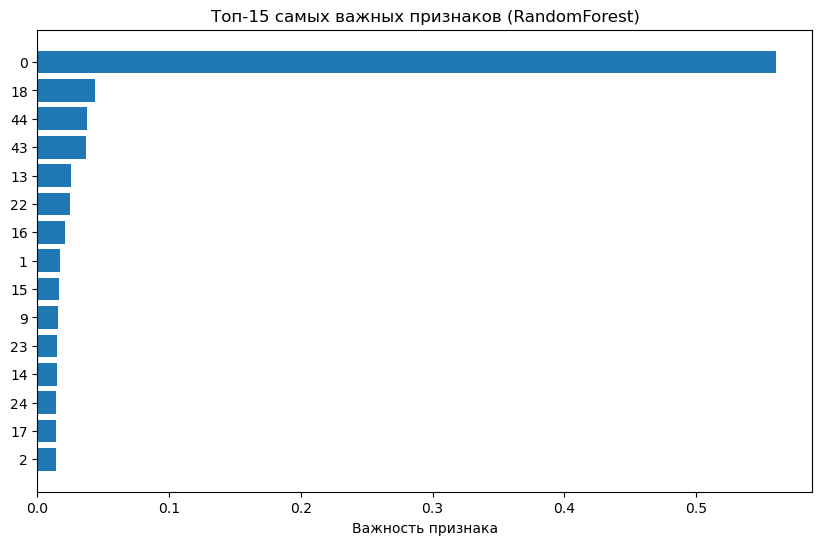

In [76]:
# Визуализация
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'].head(15).astype(str), 
         feature_importance['importance'].head(15))
plt.xlabel('Важность признака')
plt.title('Топ-15 самых важных признаков (RandomForest)')
plt.gca().invert_yaxis()
plt.show()

In [79]:
if hasattr(X_train, 'columns'):
    print(f"Признак 0: {X_train.columns[0]}")

Признак 0: Marital status


Странно, огромная важность у семейного положения, хотя корреляция таргета с ним (посчитана ниже) слабая. В остальном можно уверенно сказать, что **набор признаков действительно слабый**

In [83]:
from scipy.stats import pointbiserialr
corr, p_value = pointbiserialr(X_train['Marital status'], y_train)
print(f"Корреляция Marital status с таргетом: {corr:.3f} (p-value: {p_value:.4f})")

Корреляция Marital status с таргетом: -0.094 (p-value: 0.0000)


Я решил посмотреть на permutation importance, так как RF importance не отражает реальной прогностической силы, завышает важность скоррелированных признаков. А **permutation importance устойчив к дисбалансу и отражает реальный вклад в прогноз, лучше для интерпретации**

In [82]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(
    rf, X_test_transformed, y_test, 
    n_repeats=5, random_state=42, n_jobs=-1
)

perm_df = pd.DataFrame({
    'feature': range(X_train_transformed.shape[1]),
    'perm_importance': perm_importance.importances_mean
}).sort_values('perm_importance', ascending=False)

print("Топ-5 по permutation importance:")
perm_df.head()

Топ-5 по permutation importance:


,feature,perm_importance
0,0,0.050621
13,13,0.004972
15,15,0.004294
18,18,0.003390
11,11,0.003164


Как вы объясните полученные результаты?

__Ответ:__ **Набор признаков достаточно слабый, так как даже самый лучший признак дает только 5% улучшения**

#### __Задание 15. Softmax регрессия__ (1 балл)

Однако любознательные машинисты могут задаться вопросом "А зачем нам вся эта шляпа, если у сигмоиды есть обобщение на случай многоклассовой классификации?" Если вам понравилось считать градиенты в прошлом дз, или вам нравится обучать нейросети, этот пункт для вас. Здесь мы попробуем построить одну-единственную модель, которая будет всё предсказывать, а также сравним с вариантами выше

Начнём с подсчёта лосса. Вспомним, что логистическая функция потерь это частный случай кросс-энтропии, её и будем пытаться оптимизировать.

$$
\text{CE}(X, y) = -\frac{1}{N}\sum_i \sum_k [y_i = k] \log p(x_i = k)
$$
Вероятности в данном случае будем считать при помощи софтмакса, что есть общий случай сигмоиды

$$
p(x_i) = \text{Softmax}(a(x_i)); \quad
\text{Softmax}(x)_k = \frac{e^{x_{k}}}{\sum_j e^{x_{j}}} \\
$$

Предсказание модели на одном объекта будет делаться уже при помощи матрицы весов, посклоьку выходов несколько

$$
a(x_i) = x_i\cdot W \\
$$

Ниже предлагается написать код для такой функции потерь. Если необходимо, модифицируйте шаблон по своему усмотрению (вспомогательные функции, новые аргументы, всё, что душа пожелает)

In [86]:
!pip install torch

   ---------------------------------------- 0.0/241.3 MB ? eta -:--:--
   ---------------------------------------- 0.5/241.3 MB 5.6 MB/s eta 0:00:44
   ---------------------------------------- 1.8/241.3 MB 6.3 MB/s eta 0:00:39
   ---------------------------------------- 2.6/241.3 MB 5.0 MB/s eta 0:00:48
    --------------------------------------- 3.9/241.3 MB 5.5 MB/s eta 0:00:44
    --------------------------------------- 4.7/241.3 MB 5.6 MB/s eta 0:00:43
    --------------------------------------- 5.2/241.3 MB 4.9 MB/s eta 0:00:49
   - -------------------------------------- 6.8/241.3 MB 5.1 MB/s eta 0:00:46
   - -------------------------------------- 6.8/241.3 MB 5.1 MB/s eta 0:00:46
   - -------------------------------------- 8.1/241.3 MB 4.6 MB/s eta 0:00:51
   - -------------------------------------- 9.2/241.3 MB 4.7 MB/s eta 0:00:50
   - -------------------------------------- 10.5/241.3 MB 4.8 MB/s eta 0:00:48
   - -------------------------------------- 11.8/241.3 MB 5.0 MB/s eta

In [88]:
from typing import Iterable, Optional
from torch.nn.functional import cross_entropy
import torch

def custom_ce(
    y_pred: np.ndarray[float],
    y_true: np.ndarray[int],
) -> float:
    
    exp_pred = np.exp(y_pred - np.max(y_pred, axis=1, keepdims=True))  
    probabilities = exp_pred / np.sum(exp_pred, axis=1, keepdims=True)

    N = y_true.shape[0]
    true_class_probs = probabilities[np.arange(N), y_true]
    
    loss = -np.mean(np.log(true_class_probs + 1e-8))

    return loss

In [91]:
for _ in range(1000):

    n_objects = np.random.randint(1, 100)
    n_classes = np.random.randint(2, 20)
    y_pred = np.random.normal(0, 1, (n_objects, n_classes))
    y_true = np.random.randint(low=0, high=n_classes, size=(n_objects,))

    your_ce = custom_ce(y_pred, y_true) 
    torch_ce = cross_entropy(torch.tensor(y_pred), torch.tensor(y_true, dtype=torch.long))
    assert np.allclose(your_ce, torch_ce), "Что-то пошло не так"

Дальше самая интересная часть - нужно вывести производную этой функции потерь (на всякий случай уточним, что `torch` использовать нельзя, разве что для самопроверки). Полезные факты, которые вам могут пригодиться:

- в матричном виде найти производную непросто, попробуйте сперва сделать это для одного объекта, обобщить будет полегче
- логсофтмакс дифференцировать гораздо легче, чем просто софтмакс
- не забывайте про правило дифференцирования сложной функции
- поскольку веса в данном случае матрица, результат будет тоже матрица, учтите при сверке размерностей
- если вы не придумали, как преобразовать индикаторы в векторный вид, сейчас самое время

In [92]:
def ce_gradient(X: np.ndarray, W: np.ndarray, y: np.ndarray) -> np.ndarray[float]:
    
    N, D = X.shape
    K = W.shape[1]
    
    
    logits = X @ W
    
    
    shifted_logits = logits - np.max(logits, axis=1, keepdims=True)
    exp_logits = np.exp(shifted_logits)
    probs = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)  
    
    
    y_one_hot = np.eye(K)[y]  
    
    
    gradient = (X.T @ (probs - y_one_hot)) / N
    
    return gradient



Дальше дело за малым. Вспомните (или узнайте), как делается градиентный спуск, и дополните класс софтмакс-регрессии ниже. Здесь разумнее использовать критерий останова по итерациям, но логрег из `sklearn` устроен немного хитрее. Если хотите добавить еще критерии останова, какие-то другие параметры, то пожалуйста

In [93]:
class SoftmaxRegression:
    def __init__(self, lr=1e-3, max_iter=10000, tol=1e-4, random_state=None):
        self.W = None
        self.max_iter = max_iter
        self.lr = lr
        self.tol = tol
        self.random_state = random_state
        self.loss_history = []
        
    def fit(self, X, y):
        
        if self.random_state is not None:
            np.random.seed(self.random_state)
            
        N, D = X.shape
        self.classes_ = np.unique(y)
        K = len(self.classes_)
        
       
        self.W = np.random.normal(0, 0.01, (D, K))
        
        
        y_indices = np.searchsorted(self.classes_, y)
        
        
        prev_loss = float('inf')
        
        for i in range(self.max_iter):
            logits = X @ self.W
            shifted_logits = logits - np.max(logits, axis=1, keepdims=True)
            exp_logits = np.exp(shifted_logits)
            probs = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)
            
            true_class_probs = probs[np.arange(N), y_indices]
            loss = -np.mean(np.log(true_class_probs + 1e-8))
            self.loss_history.append(loss)
            
            if i > 0 and abs(prev_loss - loss) < self.tol:
                print(f"Converged at iteration {i}, loss: {loss:.6f}")
                break
                
            prev_loss = loss
            
            y_one_hot = np.eye(K)[y_indices]
            gradient = (X.T @ (probs - y_one_hot)) / N
            
            self.W -= self.lr * gradient
            
            if i % 1000 == 0:
                print(f"Iteration {i}, loss: {loss:.6f}")
    
    def predict_proba(self, X):
        
        logits = X @ self.W
        shifted_logits = logits - np.max(logits, axis=1, keepdims=True)
        exp_logits = np.exp(shifted_logits)
        probs = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)
        return probs
    
    def predict(self, X):
       
        probs = self.predict_proba(X)
        predictions = np.argmax(probs, axis=1)
        return self.classes_[predictions]
    
    def score(self, X, y):
        
        y_pred = self.predict(X)
        return np.mean(y_pred == y)

Обучите на тех же данных, что и выше, замерьте те же три параметра, плюс сравните значения кросс-энтропии для уже трёх моделей. Сравните модели между собой и выберите фаворита в данной задаче.

In [94]:
start_softmax = time.time()

softmax_model = SoftmaxRegression(
    lr=0.1,                    # learning rate
    max_iter=10000,            # максимальное число итераций
    tol=1e-4,                  # критерий сходимости
    random_state=42            # для воспроизводимости
)

softmax_model.fit(X_train_transformed, y_train)
time_softmax = time.time() - start_softmax

print(f'Обучение SoftmaxRegression заняло {round(time_softmax, 3)} секунд')
print(f"Размер матрицы весов: {softmax_model.W.shape}")

# Предсказания
y_pred_softmax = softmax_model.predict(X_test_transformed)

# Метрики
precision_per_class_softmax = precision_score(y_test, y_pred_softmax, average=None)
recall_per_class_softmax = recall_score(y_test, y_pred_softmax, average=None)
f1_per_class_softmax = f1_score(y_test, y_pred_softmax, average=None)


Iteration 0, loss: 1.105717
Converged at iteration 141, loss: 0.947216
Обучение SoftmaxRegression заняло 0.131 секунд
Размер матрицы весов: (45, 3)


c:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [95]:
df_metrics.loc['SoftMax Regression'] = [
    f1_per_class_softmax.mean(),
    precision_per_class_softmax.mean(),
    recall_per_class_softmax.mean(),
    softmax_model.W.shape[1],           # классов столько, сколько выходов
    round(time_softmax, 3)  
]

In [96]:
df_metrics['Количество классификаторов'] = df_metrics['Количество классификаторов'].astype(int)
display(df_metrics.style
    .background_gradient(subset=['macro_F1', 'macro_precision', 'macro_recall'], cmap='RdYlGn')
    .background_gradient(subset=['Скорость обучения (секунд)'], cmap='RdYlGn_r'))

,macro_F1,macro_precision,macro_recall,Количество классификаторов,Скорость обучения (секунд)
One-vs-Rest with Logistic Regression,0.397389,0.532561,0.434916,3,0.077000
One-vs-One with Logistic Regression,0.413611,0.535071,0.441842,3,0.064000
One-vs-One + Optuna with Logistic Regression,0.413611,0.535071,0.441842,3,2.596000
One-vs-Rest + Optuna with Logistic Regression,0.405606,0.709400,0.443286,3,2.724000
SoftMax Regression,0.393401,0.371450,0.432978,3,0.131000


__Ответ__: One-vs-One показывает лучший результат. Худшей стала Softmax регрессия, но она достаточно близко к остальным. Я думаю что SoftMax проигрывает из-за того, что строит 1 глобальную модель,а OvO строит отдельные модели для каждой пары классов => **может лучше улавливать сложнные закономерности**.\
Главная проблема данной задачи - низкое качество признаков. Я думаю, что с таким набором добиться macro F1 > 0.5 почти нереально. **Нужен feature engineering или/и новые признаки**